In [1]:
import pymysql

import pandas as pd
import logging
import warnings
warnings.filterwarnings("ignore")

import os
import sys
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
import keras.backend as K 
from keras.callbacks import EarlyStopping

import tensorflow as tf

import numpy as np
np.random.seed(42)

from datetime import datetime, timedelta
import pickle

def mape_not_zero(y_true, y_pred):
    mape = 0
    for t, p in zip(y_true, y_pred):
        if t != 0:
            mape += np.abs((t - p) / t)
        elif p != 0:
            mape += np.abs((t - p) / p)

    mape /= len(y_true)
    return np.mean(mape) * 100

def rmse(y_true, y_pred):
    mse = (np.square(y_true - y_pred)).mean(axis=0)
    return np.sqrt(mse) 

In [2]:
import pandas as pd 
df = pd.read_csv("/Users/kjh001/z_eggo/1year_user_data.csv", encoding='utf-8')
df.head()

,날짜,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,...,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,24:00:00
0,20210215,1.239,1.244,1.276,1.243,1.224,1.233,1.310,1.259,1.215,...,1.333,1.312,1.307,1.319,1.315,1.315,1.281,1.295,1.304,1.405
1,20210216,1.391,1.338,1.298,1.324,1.319,1.247,1.288,1.264,1.228,...,1.284,1.240,1.268,1.251,1.289,1.276,1.260,1.450,1.379,1.297
2,20210217,1.354,1.298,1.344,1.332,1.311,1.341,1.274,1.311,1.355,...,1.299,1.280,1.228,1.285,1.269,1.385,1.317,1.272,1.305,1.283
3,20210218,1.313,1.289,1.303,1.306,1.320,1.297,1.395,1.356,1.264,...,1.288,1.302,1.296,1.374,1.370,1.335,1.321,1.327,1.303,1.305
4,20210219,1.323,1.323,1.344,1.285,1.402,1.326,1.326,1.264,1.265,...,1.291,1.392,1.360,1.361,1.243,1.301,1.326,1.360,1.323,1.289


In [3]:
df1=df.iloc[:,1:]
vol=df1.values.tolist()
validVol=sum(vol,[]) # 1차원 배열로 만들기
# print(len(validVol)) # 시간당 전력 소모량
y=validVol
print(validVol)

[1.239, 1.244, 1.276, 1.243, 1.224, 1.233, 1.31, 1.259, 1.215, 1.491, 1.506, 1.482, 1.331, 1.339, 1.333, 1.312, 1.307, 1.319, 1.315, 1.315, 1.281, 1.295, 1.304, 1.405, 1.391, 1.338, 1.298, 1.324, 1.319, 1.247, 1.288, 1.264, 1.228, 1.268, 1.388, 1.33, 1.355, 1.317, 1.284, 1.24, 1.268, 1.251, 1.289, 1.276, 1.26, 1.45, 1.379, 1.297, 1.354, 1.298, 1.344, 1.332, 1.311, 1.341, 1.274, 1.311, 1.355, 1.341, 1.322, 1.298, 1.325, 1.318, 1.299, 1.28, 1.228, 1.285, 1.269, 1.385, 1.317, 1.272, 1.305, 1.283, 1.313, 1.289, 1.303, 1.306, 1.32, 1.297, 1.395, 1.356, 1.264, 1.245, 1.255, 1.284, 1.292, 1.271, 1.288, 1.302, 1.296, 1.374, 1.37, 1.335, 1.321, 1.327, 1.303, 1.305, 1.323, 1.323, 1.344, 1.285, 1.402, 1.326, 1.326, 1.264, 1.265, 1.304, 1.29, 1.39, 1.352, 1.271, 1.291, 1.392, 1.36, 1.361, 1.243, 1.301, 1.326, 1.36, 1.323, 1.289, 1.297, 1.317, 1.301, 1.402, 1.357, 1.356, 1.285, 1.302, 1.261, 1.36, 1.288, 1.366, 1.351, 1.431, 1.416, 1.408, 1.355, 1.362, 1.327, 1.353, 1.345, 1.294, 1.33, 1.34, 1.323,

In [4]:
d=df.날짜.values.tolist()
date=[]
for i in d:
    date.append(i)
# print(date)
dt=[]
time=['01','02','03','04','05','06','07','08','09','10','11','12'
     ,'13','14','15','16','17','18','19','20','21','22','23','24']
for i in date:
    for j in time:
        dt.append(str(i)+j)
# print(len(dt)) ## dt: 날짜시간
print(dt)


['2021021501', '2021021502', '2021021503', '2021021504', '2021021505', '2021021506', '2021021507', '2021021508', '2021021509', '2021021510', '2021021511', '2021021512', '2021021513', '2021021514', '2021021515', '2021021516', '2021021517', '2021021518', '2021021519', '2021021520', '2021021521', '2021021522', '2021021523', '2021021524', '2021021601', '2021021602', '2021021603', '2021021604', '2021021605', '2021021606', '2021021607', '2021021608', '2021021609', '2021021610', '2021021611', '2021021612', '2021021613', '2021021614', '2021021615', '2021021616', '2021021617', '2021021618', '2021021619', '2021021620', '2021021621', '2021021622', '2021021623', '2021021624', '2021021701', '2021021702', '2021021703', '2021021704', '2021021705', '2021021706', '2021021707', '2021021708', '2021021709', '2021021710', '2021021711', '2021021712', '2021021713', '2021021714', '2021021715', '2021021716', '2021021717', '2021021718', '2021021719', '2021021720', '2021021721', '2021021722', '2021021723', '2021

In [5]:
df_w = pd.read_csv("/Users/kjh001/z_eggo/weather.csv", encoding='cp949')
temp=df_w.iloc[:,3].values.tolist()
humi=df_w.iloc[:,4].values.tolist()
wind=df_w.iloc[:,5].values.tolist()

In [6]:
w=[]
weather=[]
for i in range(len(dt)):
    w.append(temp[i])
    w.append(humi[i])
    w.append(wind[i])
for i in range(0,len(w),3):
    weather.append(w[i:i+3])
print(weather) # 날씨 세개씩 묶어 feature로 만들기

[[-1, 65, 5.0], [-1, 65, 5.0], [-1, 65, 5.0], [-1, 65, 5.0], [-3, 75, 1.9], [-3, 75, 1.9], [-3, 75, 1.9], [-1, 65, 0.6], [-1, 65, 0.6], [-1, 65, 0.6], [4, 45, 5.2], [4, 45, 5.2], [4, 45, 5.2], [6, 50, 7.2], [6, 50, 7.2], [6, 50, 7.2], [3, 70, 6.0], [3, 70, 6.0], [3, 70, 6.0], [-2, 65, 3.7], [-2, 65, 3.7], [-2, 65, 3.7], [-3, 65, 4.2], [-3, 65, 4.2], [-3, 65, 4.2], [-4, 75, 4.0], [-4, 75, 4.0], [-4, 75, 4.0], [-4, 75, 4.2], [-4, 75, 4.2], [-4, 75, 4.2], [-4, 70, 7.3], [-4, 70, 7.3], [-4, 70, 7.3], [-2, 60, 8.6], [-2, 60, 8.6], [-2, 60, 8.6], [-2, 60, 9.2], [-2, 60, 9.2], [-2, 60, 9.2], [-2, 60, 5.9], [-2, 60, 5.9], [-2, 60, 5.9], [-4, 70, 6.7], [-4, 70, 6.7], [-4, 70, 6.7], [-4, 75, 6.2], [-4, 75, 6.2], [-4, 75, 6.2], [-4, 85, 5.6], [-4, 85, 5.6], [-4, 85, 5.6], [-4, 80, 5.8], [-4, 80, 5.8], [-4, 80, 5.8], [-2, 75, 5.8], [-2, 75, 5.8], [-2, 75, 5.8], [0, 55, 8.3], [0, 55, 8.3], [0, 55, 8.3], [2, 50, 8.0], [2, 50, 8.0], [2, 50, 8.0], [1, 60, 4.8], [1, 60, 4.8], [1, 60, 4.8], [-1, 70, 2.5

In [7]:
allX= np.array(weather)
allY= np.array(validVol)

trainX=allX[:7008].copy() # 8760개 데이터의 80%인 7008개를 훈련 데이터로/1752
testX=allX[7008:].copy()
trainY=allY[:7008].copy()
testY=allY[7008:].copy()


In [8]:
trainY=trainY.reshape(-1,1)
testY=testY.reshape(-1,1)
print(len(testX))
# trainX=trainX.reshape(trainX.shape[0],trainX.shape[1],1)
# testX=testX.reshape(testX.shape[0],testX.shape[1],1)

1752


In [9]:
testsize=len(testY)
timesteps=seq_length=2 # 학습시간은 2시간 마다
batch_size=1
inputs=3 ## data_dim
hiddens=3 ## hidden_dim
outputs=1 ## output_dim
learning_rate=0.0005
iterations=50000

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()
trax = scaler1.fit_transform(trainX)
tray = scaler2.fit_transform(trainY)
tstx = scaler3.fit_transform(testX)
tsty = scaler4.fit_transform(testY)

In [10]:
dataX = []
dataY = []
for i in range(0, len(tray) - seq_length):
    _x = np.copy(trax[i:i + seq_length + 1])
    _y = [tray[i + seq_length]]
    dataX.append(_x)
    dataY.append(_y)
traX = np.array(dataX[:])
traY = np.array(dataY[:])[:,:,0]  

data2X = []
data2Y = []
for i in range(0, len(tsty) - seq_length):
    _x = np.copy(tstx[i:i + seq_length + 1])
    _y = [tsty[i + seq_length]]
    data2X.append(_x)
    data2Y.append(_y)  
tstX = np.array(data2X[:])
tstY = np.array(data2Y[:])[:,:,0]  

print( traX.shape, traY.shape, tstX.shape, tstY.shape, len(tsty))

(7006, 3, 3) (7006, 1) (1750, 3, 3) (1750, 1) 1752


In [11]:
model = Sequential()  
model.add(GRU(64, batch_input_shape=(batch_size, seq_length+1, inputs),
              stateful=True, return_sequences=True,
              dropout=.1, recurrent_dropout=.2))  
model.add(GRU(32, stateful=True,
              dropout=.2, recurrent_dropout=.5))  
model.add(Dense(1))
model.summary()

Metal device set to: Apple M1


2022-05-25 00:23:18.696294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 00:23:18.696525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1, 3, 64)                13248     
                                                                 
 gru_1 (GRU)                 (1, 32)                   9408      
                                                                 
 dense (Dense)               (1, 1)                    33        
                                                                 
Total params: 22,689
Trainable params: 22,689
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='mse', optimizer='adam') 
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
hist = model.fit(traX, traY, epochs=100,
                 batch_size=batch_size, verbose=1, 
                 callbacks=[early_stop],
                 validation_data=(tstX, tstY))

Epoch 1/100


2022-05-25 00:23:20.200541: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-25 00:23:26.903779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7006/7006 [==============================] - ETA: 0s - loss: 0.0087

2022-05-25 00:44:50.474800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7006/7006 [==============================] - 1353s 192ms/step - loss: 0.0087 - val_loss: 0.0167
Epoch 2/100
7006/7006 [==============================] - 1203s 172ms/step - loss: 0.0081 - val_loss: 0.0225
Epoch 3/100
7006/7006 [==============================] - 1020s 146ms/step - loss: 0.0080 - val_loss: 0.0157
Epoch 4/100
7006/7006 [==============================] - 680s 97ms/step - loss: 0.0080 - val_loss: 0.0191
Epoch 5/100
7006/7006 [==============================] - 2505s 358ms/step - loss: 0.0079 - val_loss: 0.0155
Epoch 6/100
7006/7006 [==============================] - 9042s 1s/step - loss: 0.0079 - val_loss: 0.0159
Epoch 7/100
7006/7006 [==============================] - 6121s 874ms/step - loss: 0.0079 - val_loss: 0.0157
Epoch 8/100
7006/7006 [==============================] - 8078s 1s/step - loss: 0.0078 - val_loss: 0.0158
Epoch 9/100
7006/7006 [==============================] - 7456s 1s/step - loss: 0.0078 - val_loss: 0.0165
Epoch 10/100
7006/7006 [===========================

In [37]:
testmse = model.evaluate(tstX, tstY, batch_size=1)
testmse

1750/1750 [==============================] - 22s 13ms/step - loss: 0.3921


0.3921125531196594

In [54]:
predictions = model.predict(tstX, batch_size=1)
preds = scaler4.inverse_transform(predictions)

In [55]:
print(predictions)

[[0.0537884 ]
 [0.04121833]
 [0.04576078]
 ...
 [0.11100797]
 [0.09413787]
 [0.06803574]]


In [56]:
print(preds)

[[0.29495415]
 [0.23139988]
 [0.2543665 ]
 ...
 [0.5842563 ]
 [0.49896106]
 [0.3669887 ]]


In [57]:
print(tsty)
max(tsty)

[[0.602]
 [2.292]
 [2.983]
 ...
 [0.057]
 [0.056]
 [0.052]]


array([5.079])

In [58]:
def mape_not_zero(y_true, y_pred):
    mape = 0
    for t, p in zip(y_true, y_pred):
        if t != 0:
            mape += np.abs((t - p) / t)
        elif p != 0:
            mape += np.abs((t - p) / p)

    mape /= len(y_true)
    return np.mean(mape) * 100

testmape = mape_not_zero(testY[:], preds[:])
print(testmape)

1021.1350392881119


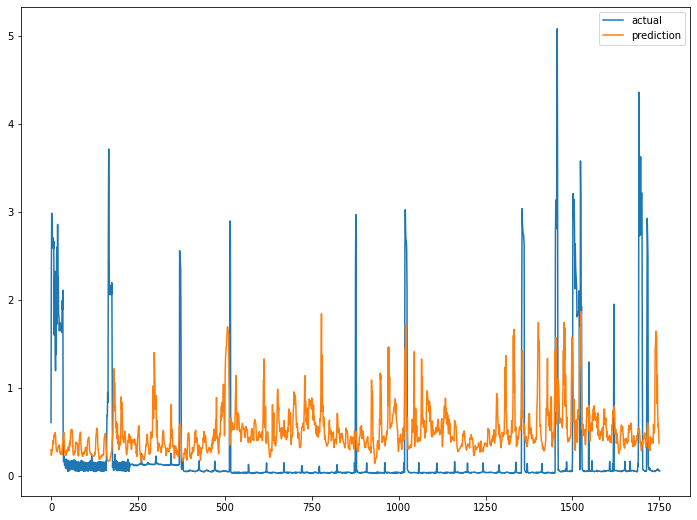

In [62]:
plt.figure(figsize=(12,9))
plt.plot(tsty,label='actual')
plt.plot(preds,label='prediction')

plt.legend()

plt.show()

In [64]:
pk1_path="model/model_rnn_eggo.pkl"
with open(pk1_path,'wb') as f:
    pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://906816e2-411e-43cc-abf3-59e4a50440c2/assets


INFO:tensorflow:Assets written to: ram://906816e2-411e-43cc-abf3-59e4a50440c2/assets
